Initializing network with architecture: [11, 3, 1]
Initializing network with architecture: [11, 3, 1]
Initializing network with architecture: [11, 3, 1]


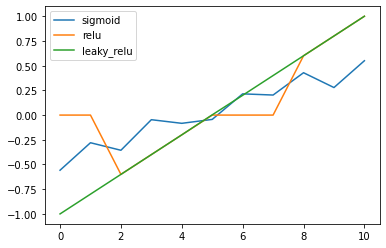

In [1]:
%run MyNeuralNetwork.ipynb

In [91]:
import numpy as np
from math import sqrt

# Helper functions
def sigmoid(x):
    x = np.clip(x, -500, 500) # not to run into overflow error
    return 1 / (1 + np.exp(-x))

def sigmoid_derived(x):
    x = np.clip(x, -100, 100) # not to run into overflow error
    return np.exp(x)/(1 + np.exp(x))**2

def relu(x):
    return x * (x > 0)

def relu_derived(x):
    return 1. * (x > 0)

def leaky_relu(x):
    return x * (x > 0) + 0.01 * x * (x < 0)

def leaky_relu_derived(x):
    return 1.0 * (x > 0) + 0.01 * (x < 0)

class MyNeuralNetwork():
    '''
    Activation function in hidden layers is sigmoid. 
    Output layer is linear for now (regression problems only).
    '''
    
    def __init__(self, architecture, activation, activation_derived):

        print("Initializing network with architecture:", architecture, " Activation: ", activation.__name__)
        
        self.architecture = architecture  # Array describing network structure, first is input, last is output all others are hidden
        self.input_size = architecture[0] # Input features size
        self.layers = len(architecture)   # Number of Layers
        
        self.W = [] # list of weight matrices
        self.initialize_W()
        
        self.activation = activation
        self.activation_derived = activation_derived
        
    def initialize_W(self):
        '''
        Initializes weights from N(0, 1/sqrt(input_features_size))
        '''
        for i in range(self.layers - 1):
            tmp_W = np.random.normal(loc = 0, scale = 1/sqrt(self.input_size), size = self.architecture[i:i+2])
            self.W.append(tmp_W)
    
    def feedforward_one_step(self, x, layer):
        y = np.dot(x, self.W[layer])
        if layer == self.layers - 2:  # Do not apply activation function in output layer calculations
            return y
        else:                         # Apply activation function
            return self.activation(y)
    
    def feedforward(self, x):
        '''For a given input vector column calculate output'''
        for layer in range(self.layers - 1):
            x = self.feedforward_one_step(x, layer)
        return x
    
    def feedforward_full(self, x):
        '''For a given input vector column feature vector for each layer'''
        list_x = []
        x.shape = (1, x.size)
        list_x.append(x)
        
        for layer in range(self.layers - 1):
            x = self.feedforward_one_step(x, layer)
            x.shape = (1, x.size)
            list_x.append(x)

        return list_x
    
    def backpropagation(self, x, y, alpha = 0.01, print_ = False):
        list_x = self.feedforward_full(x) # Ima indekse 0, 1, 2, 3
        gradients = []
        delta = 1
        for layer in range(self.layers - 2, -1, -1):  ## ide 2, 1, 0
            new_gradient = np.dot(delta, list_x[layer])
            new_gradient = np.transpose(new_gradient)
            gradients.append(new_gradient)
            
            if(layer > 0):
                psi = np.dot(list_x[layer-1], self.W[layer-1])
                sigm_d = np.eye(psi.size) * self.activation_derived(psi)
                delta = np.dot(np.dot(sigm_d, self.W[layer]), delta)
        gradients.reverse()
        
        error = list_x[-1] - y
        # We have gradients, now we just apply them
        for i, W in enumerate(self.W):
            
            if print_:
                print("Current Weights: \n", self.W[i], 
                      "\nNet Estimate", list_x[-1],
                      "\nError: \n", error,
                     "\nGradient: \n", gradients[i],
                     "\n Update: \n", - alpha * error * gradients[i])

            self.W[i] = self.W[i] - alpha * error * gradients[i]
        return

In [92]:
n_states = 501

net = MyNeuralNetwork([n_states, 250, 1], leaky_relu, leaky_relu_derived)
net_sigmoid = MyNeuralNetwork([n_states, 250, 1], sigmoid, sigmoid_derived)

Initializing network with architecture: [501, 250, 1]  Activation:  leaky_relu
Initializing network with architecture: [501, 250, 1]  Activation:  sigmoid


In [93]:
# All States
s = np.array(range(n_states))
v = np.zeros(n_states)
v_sigmoid = np.zeros(n_states)

In [94]:
def state_to_vector(s):
    x = np.zeros(n_states)
    x[s] = 1
    return x

In [95]:
import matplotlib.pyplot as plt

In [115]:
for state in s:
    x = state_to_vector(state)
    v[state] = net.feedforward(x)
    v_sigmoid[state] = net_sigmoid.feedforward(x)

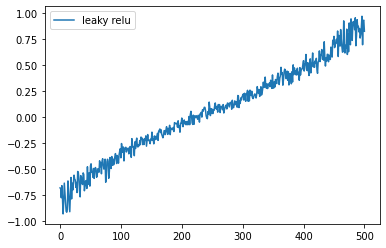

In [116]:
plt.plot(s, v, label = "leaky relu")
#plt.plot(s, v_sigmoid, label = 'sigmoid')
plt.legend()

In [114]:
for i in range(300):
    if i % 10 == 0:
        print(i)
        
    current_state = 250
    terminal = False

    while terminal == False:
        jump = np.random.randint(-50, 50+1)
        next_state = current_state + jump

        reward = 0
        if next_state > 500:
            reward = 1
            terminal = True
        elif next_state < 0:
            terminal = True
            reward = -1
        else:
            pass

        #if terminal: print("Current State: ", current_state)
        #if terminal: print("Next State: ", next_state)
        #if terminal: print("Reward: ", reward)
        
        if terminal:
            target = reward
        else:
            target = reward + net.feedforward(state_to_vector(next_state))
        #if terminal: print("Target: ", target)
        #if terminal: print("State value before: ", net.feedforward(state_to_vector(current_state)))
        #if terminal: print("State 0 value before: ", net.feedforward(state_to_vector(0)))
        
        net.backpropagation(state_to_vector(current_state), target, alpha = 0.3)
        #net_sigmoid.backpropagation(state_to_vector(current_state), target, alpha = 0.01)
        #if terminal: print("State value after: ", net.feedforward(state_to_vector(current_state)))
        #if terminal: print("State 0 value after: ", net.feedforward(state_to_vector(0)))
        current_state = next_state

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [411]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.linspace(-1, 1, num = 11)

n2 = MyNeuralNetwork([11, 5, 1])

def state_to_vector(s):
    x = np.zeros(11)
    x[s] = 1
    return x

Initializing network with architecture: [11, 5, 1]


In [583]:
for i in range(10000):
    index = np.random.randint(0, 11)
    #print("State: ", index)
    #print("Target: ", y[index])
    #print("Before: ", n2.feedforward(state_to_vector(x[index])))
    #print("Before state 0: ", n2.feedforward(state_to_vector(0)))
    n2.backpropagation(state_to_vector(x[index]), y[index], alpha = 0.01)
    #print("After: ", n2.feedforward(state_to_vector(x[index])))
    #print("After state 0: ", n2.feedforward(state_to_vector(0)))

In [584]:
v = np.zeros(11)
for i in range(len(x)):
    v[i] = n2.feedforward(state_to_vector(i))

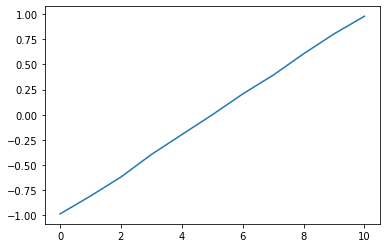

In [585]:
plt.plot(x, v)

In [283]:
np.random.randint(0, 1)

0